In [19]:
# CPU-only; fine for Kaggle. If a PyG wheel mismatch happens,
# re-run just this cell (Kaggle sometimes needs a second attempt).
!pip -q install mne pyedflib numpy scipy pandas matplotlib scikit-learn
!pip -q install torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cpu.html


In [20]:
import os, glob, json, math, random, warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import mne
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.signal import welch, iirnotch, filtfilt
from sklearn.preprocessing import StandardScaler

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, global_mean_pool


In [23]:
# ====== CHANGE THIS TO YOUR KAGGLE DATASET NAME ======
DATA_ROOT = Path("/kaggle/input/tuh-eeg-data")     # your private dataset
BASE_TUSZ = DATA_ROOT / "train"                # we’ll start with /train

# 10-20 TCP montage (bipolar pairs). Clinical: common “TCP montage” for seizure work-ups.
TCP_PAIRS = [
    ('FP1','F7'), ('F7','T3'), ('T3','T5'), ('T5','O1'),
    ('FP2','F8'), ('F8','T4'), ('T4','T6'), ('T6','O2'),
    ('A1','T3'), ('T3','C3'), ('C3','CZ'), ('CZ','C4'),
    ('C4','T4'), ('T4','A2'), ('FP1','F3'), ('F3','C3'),
    ('C3','P3'), ('P3','O1'), ('FP2','F4'), ('F4','C4'),
    ('C4','P4'), ('P4','O2')
]
TCP_NAMES = [f"{a}-{b}" for a,b in TCP_PAIRS]

# analysis defaults
RESAMPLE_HZ = 256              # Clinical: 256 Hz covers conventional scalp bandwidth
BANDPASS = (0.5, 70.0)         # Conventional clinical scalp band
NOTCH_HZ = 60                  # US power-line; set 50 if data is EU-origin
WIN_SEC = 20                   # interictal window length
STEP_SEC = 10                  # 50% overlap
SEIZ_PAD_SEC = 120             # remove +/- 2 min around seizures (avoid post-ictal confounds)
TOPK_EDGES = 6                 # sparsify connectivity


In [24]:
# quick sanity: show first 3 .edf anywhere under the root
print("Sanity check: first few EDFs under DATA_ROOT:")
for i, p in enumerate(glob.glob(str(DATA_ROOT / "**" / "*.edf"), recursive=True)[:3], 1):
    print(f"{i}. {p}")
if i == 0:
    print("No EDFs found under DATA_ROOT. Check the dataset name/structure.")

def list_edfs(base: Path):
    return sorted(glob.glob(str(base / "**" / "*.edf"), recursive=True))

def csv_bi_for(edf_path: str) -> str:
    return edf_path.replace(".edf", ".csv_bi")

def csv_evt_for(edf_path: str) -> str:
    return edf_path.replace(".edf", ".csv")

def has_annotation(edf_path: str) -> bool:
    return os.path.exists(csv_bi_for(edf_path)) or os.path.exists(csv_evt_for(edf_path))

# scan
all_edfs = list_edfs(BASE_TUSZ)
edfs = [p for p in all_edfs if has_annotation(p)]

print(f"\nTotal EDFs found under BASE_TUSZ ({BASE_TUSZ}): {len(all_edfs)}")
print(f"EDFs with annotations (.csv or .csv_bi): {len(edfs)}")
print("\nExample EDF with annotation:", edfs[0] if edfs else "NONE")
if edfs:
    e = edfs[0]
    print("CSV exists?   ", os.path.exists(csv_evt_for(e)))
    print("CSV_BI exists?", os.path.exists(csv_bi_for(e)))

Sanity check: first few EDFs under DATA_ROOT:
1. /kaggle/input/tuh-eeg-data/train/aaaaabbd/s001_2003/02_tcp_le/aaaaabbd_s001_t000.edf
2. /kaggle/input/tuh-eeg-data/train/aaaaabbd/s001_2003/02_tcp_le/aaaaabbd_s001_t001.edf
3. /kaggle/input/tuh-eeg-data/train/aaaaabdv/s001_2003/02_tcp_le/aaaaabdv_s001_t000.edf

Total EDFs found under BASE_TUSZ (/kaggle/input/tuh-eeg-data/train): 173
EDFs with annotations (.csv or .csv_bi): 173

Example EDF with annotation: /kaggle/input/tuh-eeg-data/train/aaaaaaac/s001_2002/02_tcp_le/aaaaaaac_s001_t000.edf
CSV exists?    True
CSV_BI exists? True


In [26]:
def read_seizure_intervals_any(edf_path: str):
    """
    Returns a list of (t0, t1) seizure intervals in seconds for the given EDF.
    Supports both:
      - .csv_bi (term-based; usually 3 columns: label,t0,t1)
      - .csv    (event-based; per-channel; 4-5 columns)
    We 'union' intervals across channels for .csv.
    """
    bi = csv_bi_for(edf_path)
    ev = csv_evt_for(edf_path)

    if os.path.exists(bi):
        # Try robust load: unknown separators or spaces handled
        df = pd.read_csv(bi, header=None, engine="python")
        # Find label col (string-ish) and two numeric cols for times
        col_is_num = [pd.to_numeric(df[c], errors="coerce").notna().mean() > 0.8 for c in df.columns]
        num_cols = [i for i,ok in enumerate(col_is_num) if ok]
        str_cols = [i for i,ok in enumerate(col_is_num) if not ok]

        if len(num_cols) < 2 or len(str_cols) < 1:
            return []

        intervals = []
        for _, row in df.iterrows():
            # pick label from the first string-like column
            label = str(row[str_cols[0]]).lower()
            # pick first two numeric-like columns as times
            nums = []
            for j in num_cols:
                try: nums.append(float(row[j]))
                except: pass
            if len(nums) >= 2:
                t0, t1 = sorted(nums[:2])
                if "seiz" in label:  # keep seizures only
                    intervals.append((t0, t1))
        return intervals

    elif os.path.exists(ev):
        # Event-based: per-channel. We need to union across channels.
        df = pd.read_csv(ev, header=None, engine="python")
        col_is_num = [pd.to_numeric(df[c], errors="coerce").notna().mean() > 0.8 for c in df.columns]
        num_cols = [i for i,ok in enumerate(col_is_num) if ok]
        str_cols = [i for i,ok in enumerate(col_is_num) if not ok]

        intervals = []
        for _, row in df.iterrows():
            label = None
            for i in str_cols:
                v = str(row[i]).lower()
                # look for seizure-like labels (covers TUSZ multi-class too)
                if any(k in v for k in ["seiz","fnsz","gnsz","cpsz","absz","tnsz","tcsz","mysz","spsz","tisz","nusz"]):
                    label = v; break
            if label is None:
                continue

            # grab two time-like numbers from numeric columns
            nums = []
            for j in num_cols:
                try: nums.append(float(row[j]))
                except: pass
            if len(nums) < 2:
                continue
            t0, t1 = sorted(nums[:2])
            intervals.append((t0, t1))

        if not intervals:
            return []

        # merge overlaps (union across channels)
        intervals = sorted(intervals)
        merged = []
        cs, ce = intervals[0]
        for s,e in intervals[1:]:
            if s <= ce:
                ce = max(ce, e)
            else:
                merged.append((cs, ce)); cs, ce = s, e
        merged.append((cs, ce))
        return merged

    else:
        # No annotations found
        return []

In [30]:
import os, json
import pandas as pd
import mne

def peek_edf_info(edf_path):
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    return {
        "file": edf_path,
        "n_channels": len(raw.ch_names),
        "sfreq": float(raw.info["sfreq"]),
        "first_5_ch": raw.ch_names[:5],
    }

def _read_any_table(path: str) -> pd.DataFrame:
    """
    Robust CSV/TSV/space reader:
    - sep=None lets pandas infer commas/tabs/spaces
    - on_bad_lines='skip' drops malformed lines
    - comment='#' ignores header comments if any
    """
    return pd.read_csv(path, header=None, sep=None, engine="python",
                       on_bad_lines="skip", comment="#")

import pandas as pd, os

def read_annotations_any(edf_path):
    bi = edf_path.replace(".edf", ".csv_bi")
    ev = edf_path.replace(".edf", ".csv")

    path = bi if os.path.exists(bi) else ev if os.path.exists(ev) else None
    if path is None:
        print("⚠️ No annotation file found.")
        return pd.DataFrame(columns=["label","t0","t1"])

    # skip comment lines and header
    df = pd.read_csv(
        path,
        comment="#",
        header=0,                     # header line: channel,start_time,stop_time,label,confidence
    )

    # keep only seizure intervals (label contains 'seiz')
    df = df[df["label"].astype(str).str.contains("seiz", case=False, na=False)]
    return df.rename(columns={"start_time":"t0","stop_time":"t1"})[["label","t0","t1"]]
    return pd.DataFrame(columns=["label","t0","t1"])

    df = _read_any_table(path)

    # Identify numeric vs string-like columns
    is_num = [pd.to_numeric(df[c], errors="coerce").notna().mean() > 0.8 for c in df.columns]
    num_cols = [i for i,b in enumerate(is_num) if b]
    str_cols = [i for i,b in enumerate(is_num) if not b]

    # Pick label column (contains 'seiz' somewhere)
    label_col = None
    for c in str_cols:
        if df[c].astype(str).str.contains("seiz", case=False, na=False).any():
            label_col = c; break
    if label_col is None:
        # fall back to first string-like col
        label_col = str_cols[0] if str_cols else df.columns[-1]

    # Need two numeric columns for times
    if len(num_cols) < 2:
        # relax if needed
        num_cols = [i for i in df.columns if pd.to_numeric(df[i], errors="coerce").notna().mean() > 0.5]
        if len(num_cols) < 2:
            return pd.DataFrame(columns=["label","t0","t1"])

    # Build seizure intervals
    recs = []
    for _, row in df.iterrows():
        lab = str(row[label_col]).lower()
        if "seiz" not in lab:
            continue
        times = []
        for c in num_cols:
            try: times.append(float(row[c]))
            except: pass
        if len(times) >= 2:
            t0, t1 = sorted(times[:2])
            recs.append((lab, t0, t1))
    if not recs:
        return pd.DataFrame(columns=["label","t0","t1"])

    # Merge overlaps across channels
    tmp = pd.DataFrame(recs, columns=["label","t0","t1"]).sort_values("t0")
    merged = []
    for t0, t1 in tmp[["t0","t1"]].to_numpy():
        if not merged or t0 > merged[-1][1]:
            merged.append([t0, t1])
        else:
            merged[-1][1] = max(merged[-1][1], t1)
    return pd.DataFrame([("seiz", a, b) for a,b in merged], columns=["label","t0","t1"])

# ---- demo on first EDF with annotations ----
if edfs:
    ex = edfs[0]
    print(json.dumps(peek_edf_info(ex), indent=2))
    ann = read_annotations_any(ex)
    print("\nAnnotations head:\n", ann.head())
else:
    print("No EDFs found under BASE_TUSZ — verify your BASE_TUSZ path.")


{
  "file": "/kaggle/input/tuh-eeg-data/train/aaaaaaac/s001_2002/02_tcp_le/aaaaaaac_s001_t000.edf",
  "n_channels": 33,
  "sfreq": 250.0,
  "first_5_ch": [
    "EEG FP1-LE",
    "EEG FP2-LE",
    "EEG F3-LE",
    "EEG F4-LE",
    "EEG C3-LE"
  ]
}

Annotations head:
   label       t0        t1
0  seiz  36.8868  237.2101


In [32]:
# TCP montage pairs (bipolar)
TCP_PAIRS = [
    ('FP1','F7'), ('F7','T3'), ('T3','T5'), ('T5','O1'),
    ('FP2','F8'), ('F8','T4'), ('T4','T6'), ('T6','O2'),
    ('A1','T3'), ('T3','C3'), ('C3','CZ'), ('CZ','C4'),
    ('C4','T4'), ('T4','A2'), ('FP1','F3'), ('F3','C3'),
    ('C3','P3'), ('P3','O1'), ('FP2','F4'), ('F4','C4'),
    ('C4','P4'), ('P4','O2')
]
TCP_NAMES = [f"{a}-{b}" for a,b in TCP_PAIRS]

# analysis defaults
RESAMPLE_HZ = 256
BANDPASS    = (0.5, 70.0)
NOTCH_HZ    = 60  # set to 50 in EU grids

def load_tcp_raw(edf_path, resample_hz=RESAMPLE_HZ, notch=NOTCH_HZ):
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    # find REF/LE/AR channels by name
    def find_chan(base):
        for suf in ("-LE", "-REF", "-AR", ""):
            nm = f"EEG {base}{suf}"
            if nm in raw.ch_names:
                return nm
        return None

    # create bipolar derivations
    for a,b in TCP_PAIRS:
        an, bn = find_chan(a), find_chan(b)
        if an and bn:
            mne.set_bipolar_reference(raw, anode=an, cathode=bn,
                                      ch_name=f"{a}-{b}", drop_refs=False, copy=False)

    picks = [ch for ch in TCP_NAMES if ch in raw.ch_names]
    if len(picks) < 12:
        raise RuntimeError(f"Too few TCP channels found: {len(picks)}")
    raw.pick_channels(picks).reorder_channels(picks)

    # filter + notch + resample
    raw.filter(BANDPASS[0], BANDPASS[1], fir_design='firwin', verbose=False)
    if notch: raw.notch_filter(freqs=[notch, 2*notch], verbose=False)
    raw.resample(resample_hz)
    return raw

In [41]:
import numpy as np
import pandas as pd
import mne

def interictal_windows_adaptive(edf_path, win_sec=20, step_sec=10, pad_max_sec=60, pad_frac=0.10,
                                band=(0.5,70), notch=60, resample_hz=256, tcp_pairs=None, tcp_names=None):
    # load raw with your existing loader
    raw = load_tcp_raw(edf_path, resample_hz=resample_hz, notch=notch)
    sf = raw.info['sfreq']
    X  = raw.get_data()
    T  = X.shape[1] / sf
    win = int(win_sec*sf)
    step= int(step_sec*sf)

    # adaptive padding: fraction of recording but capped
    pad_sec = min(pad_max_sec, pad_frac * T)

    ann = read_annotations_any(edf_path)
    seiz = [(max(0.0, float(a)-pad_sec), min(T, float(b)+pad_sec))
            for a,b in ann[['t0','t1']].to_numpy()] if len(ann) else []

    # Merge overlapping exclusion windows
    intervals = sorted(seiz, key=lambda x: x[0])
    merged = []
    for s,e in intervals:
        if not merged or s > merged[-1][1]:
            merged.append([s,e])
        else:
            merged[-1][1] = max(merged[-1][1], e)

    # Compute *kept* ranges (diagnostics)
    keep = []
    cur = 0.0
    for s,e in merged:
        if cur < s: keep.append((cur, s))
        cur = max(cur, e)
    if cur < T: keep.append((cur, T))

    # windowing
    data = raw.get_data()
    chunks, t0s = [], []
    for (a,b) in keep:
        a_i, b_i = int(a*sf), int(b*sf)
        s = a_i
        while s + win <= b_i:
            chunks.append(data[:, s:s+win])
            t0s.append(s/sf)
            s += int(step)

    chunks = np.stack(chunks) if chunks else np.empty((0, data.shape[0], win))

    # print diagnostics
    print(f"Duration: {T:.1f}s | seizures: {[(round(s,1), round(e,1)) for s,e in ann[['t0','t1']].to_numpy()] if len(ann) else 'none'}")
    print(f"Pad used: ±{pad_sec:.1f}s | excluded after pad: {[(round(s,1), round(e,1)) for s,e in merged] if merged else 'none'}")
    print(f"Kept ranges: {[(round(a,1), round(b,1)) for a,b in keep] if keep else 'none'}")
    print(f"Interictal windows: {chunks.shape}")

    return chunks, t0s, sf, raw.ch_names



EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=75250
    Range : 0 ... 75249 =      0.000 ...   300.996 secs
Ready.
Added the following bipolar channels:
FP1-F7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=75250
    Range : 0 ... 75249 =      0.000 ...   300.996 secs
Ready.
Added the following bipolar channels:
F7-T3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=75250
    Range : 0 ... 75249 =      0.000 ...   300.996 secs
Ready.
Added the following bipolar channels:
T3-T5
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=75250
    Range : 0 ... 75249 =      0.000 ...   300.996 secs
Ready.
Added the following bipolar channels:
T5-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=75250
    Range : 0 ... 752

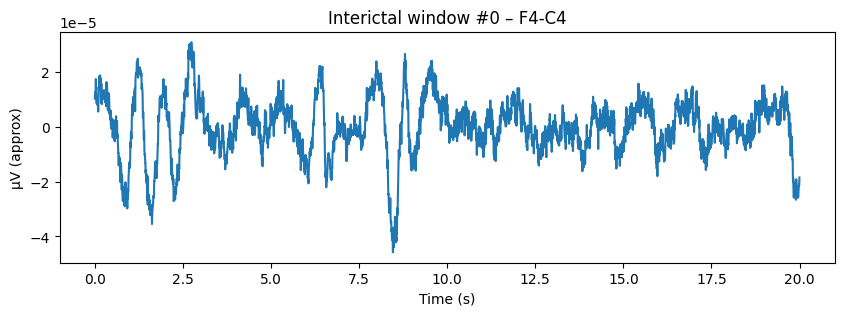

In [42]:
X, t0s, sf, chs = interictal_windows_adaptive(ex, pad_max_sec=60, pad_frac=0.10)
plot_sample(X, chs, sf, k=0)


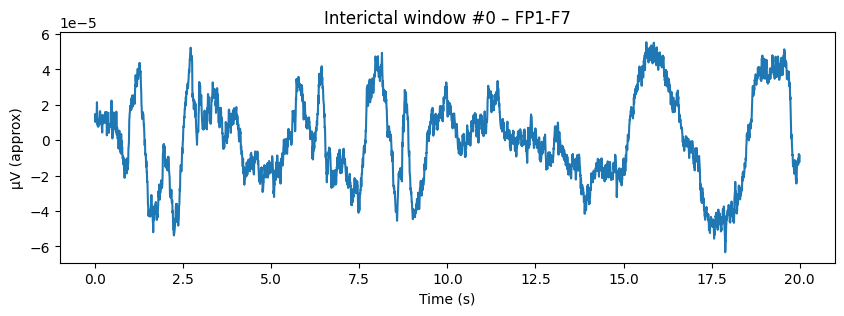

In [44]:
import matplotlib.pyplot as plt

def plot_sample(chunks, ch_names, sf, k=0, ch="P4-02"):
    if len(chunks)==0:
        print("No interictal windows found for this file after padding. Try another EDF.")
        return
    if ch not in ch_names:
        ch = ch_names[0]
    ci = ch_names.index(ch)
    sig = chunks[k, ci]  # one window, one channel

    t = np.arange(sig.size)/sf
    plt.figure(figsize=(10,3))
    plt.plot(t, sig)
    plt.title(f"Interictal window #{k} – {ch}")
    plt.xlabel("Time (s)"); plt.ylabel("µV (approx)")
    plt.show()

plot_sample(X, chs, sf, k=0)


In [45]:
from scipy.signal import welch

BANDS = [(1,4),(4,8),(8,12),(12,30),(30,45)]

def bandpower_window(x_22_T, sf):
    f, Pxx = welch(x_22_T, fs=sf, nperseg=min(256, x_22_T.shape[1]))
    feats=[]
    for (f1,f2) in BANDS:
        m=(f>=f1)&(f<=f2)
        feats.append( np.log(Pxx[:,m].mean(axis=1, keepdims=True)+1e-9) )
    return np.concatenate(feats, axis=1).astype(np.float32)  # [C,5]

def graph_from_window(x_22_T, sf, topk=6):
    node_x = bandpower_window(x_22_T, sf)  # [C,5]
    c = np.corrcoef(x_22_T); np.fill_diagonal(c, 0)
    A = np.zeros_like(c)
    for i in range(c.shape[0]):
        idx = np.argsort(np.abs(c[i]))[::-1][:topk]
        A[i, idx] = np.abs(c[i, idx])
    A = np.maximum(A, A.T)
    src, dst = np.nonzero(A)
    edge_attr = A[src, dst].astype(np.float32)[:,None]
    return node_x, np.vstack([src,dst]).astype(np.int64), edge_attr
